In [11]:
import os
import numpy as np
import pandas as pd

data_path = os.path.join("eDo", 'data', 'processed_with_targets.csv')
df = pd.read_csv(data_path, parse_dates=['DateTime'])
df.sort_values("DateTime", inplace=True)
df.columns

Index(['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'log_ret',
       'fracdiff', 'Return_next_10', 'ReturnBin10', 'ReturnBinQuantile',
       'ReturnBin10_manual', 'ReturnBin10_manual_bell'],
      dtype='object')

# Astrology features

...god i hate technical indicators

In [28]:
import pandas as pd
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands, AverageTrueRange

rsi_indicator = RSIIndicator(close=df['Close'], window=14)
for rsi_window in [7, 14, 28]:
    rsi_indicator = RSIIndicator(close=df['Close'], window=rsi_window)
    df[f'RSI_{rsi_window}'] = rsi_indicator.rsi()


# Common defaults: window_slow=26, window_fast=12, window_sign=9
macd_default = MACD(
    close=df['Close'],
    window_slow=26,
    window_fast=12,
    window_sign=9
)
df['MACD_26_12']       = macd_default.macd()
df['MACD_signal_26_12'] = macd_default.macd_signal()
df['MACD_diff_26_12']   = macd_default.macd_diff()

# Short-term MACD
macd_short = MACD(
    close=df['Close'],
    window_slow=19,
    window_fast=8,
    window_sign=9
)
df['MACD_19_8']       = macd_short.macd()
df['MACD_signal_19_8'] = macd_short.macd_signal()
df['MACD_diff_19_8']   = macd_short.macd_diff()

for stoch_window in [7, 14, 21]:
    stoch_indicator = StochasticOscillator(
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        window=stoch_window,
        smooth_window=3
    )
    df[f'%K_{stoch_window}'] = stoch_indicator.stoch()
    df[f'%D_{stoch_window}'] = stoch_indicator.stoch_signal()


for atr_window in [7, 14, 28]:
    atr_indicator = AverageTrueRange(
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        window=atr_window
    )
    df[f'ATR_{atr_window}'] = atr_indicator.average_true_range()


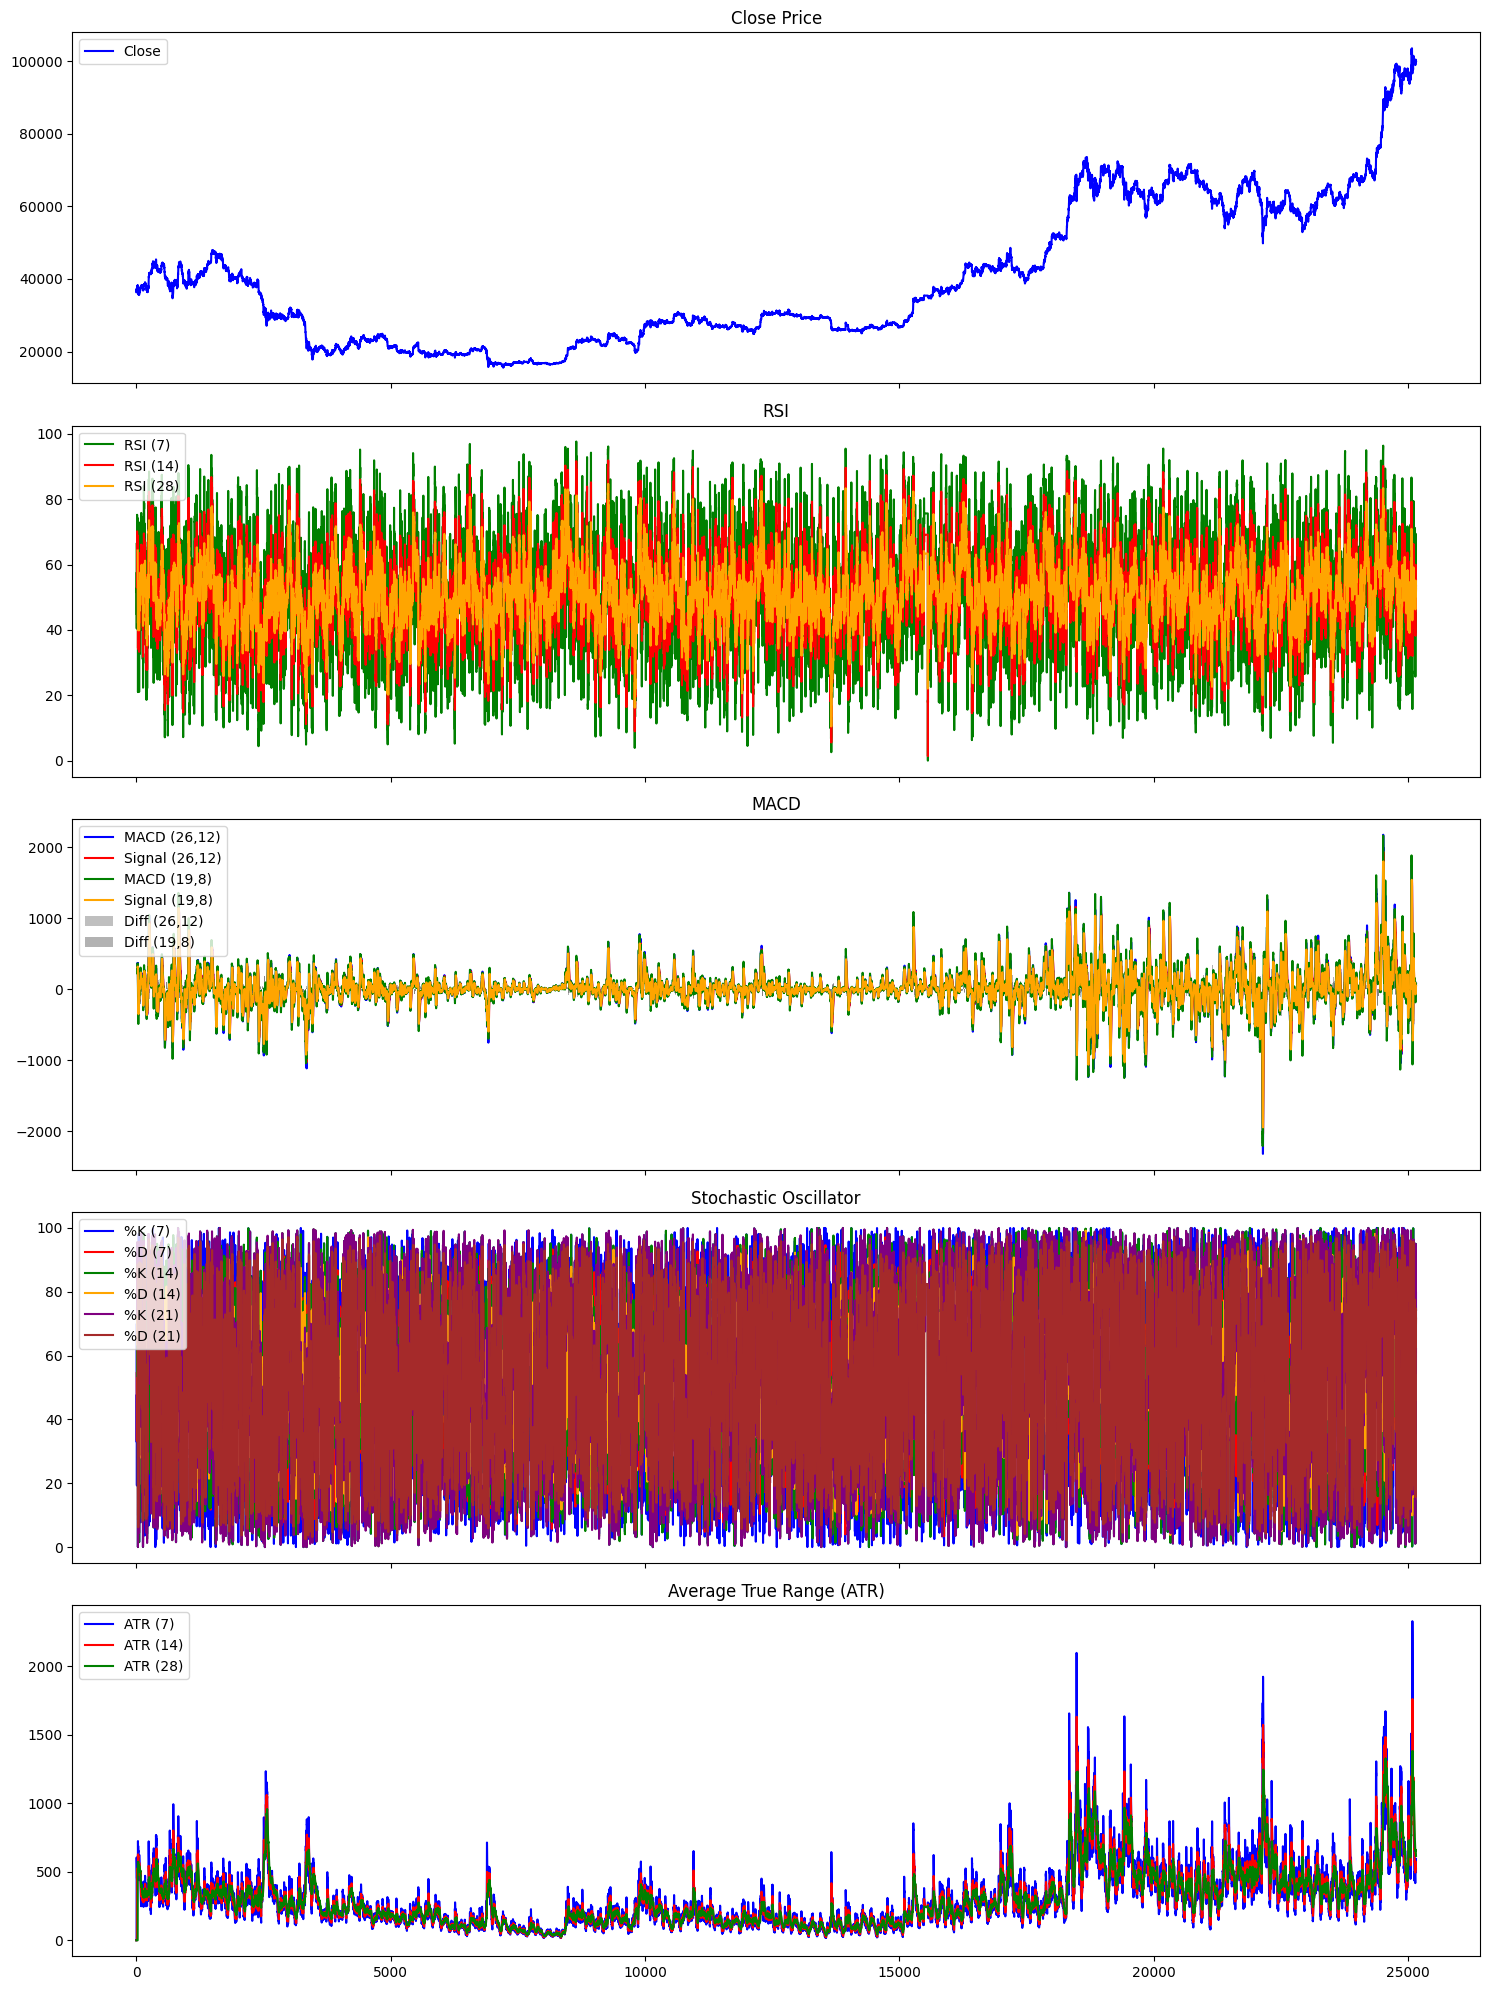

In [29]:
import matplotlib.pyplot as plt

# Ensure your DataFrame index is a datetime index (if you're dealing with time series)
# e.g., df.index = pd.to_datetime(df['Date']) 
# df.set_index('Date', inplace=True)  # if needed

fig, axes = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

# --- 1) Plot Closing Price ---
axes[0].plot(df.index, df['Close'], label='Close', color='blue')
axes[0].set_title('Close Price')
axes[0].legend(loc='upper left')

# --- 2) Plot RSI (for windows 7, 14, 28) ---
axes[1].plot(df.index, df['RSI_7'], label='RSI (7)', color='green')
axes[1].plot(df.index, df['RSI_14'], label='RSI (14)', color='red')
axes[1].plot(df.index, df['RSI_28'], label='RSI (28)', color='orange')
axes[1].set_title('RSI')
axes[1].legend(loc='upper left')

# --- 3) Plot MACD (Default and Short-Term) ---
axes[2].set_title('MACD')
# Default MACD
axes[2].plot(df.index, df['MACD_26_12'], label='MACD (26,12)', color='blue')
axes[2].plot(df.index, df['MACD_signal_26_12'], label='Signal (26,12)', color='red')
axes[2].bar(df.index, df['MACD_diff_26_12'], label='Diff (26,12)', color='gray', alpha=0.5)

# Short-term MACD
axes[2].plot(df.index, df['MACD_19_8'], label='MACD (19,8)', color='green')
axes[2].plot(df.index, df['MACD_signal_19_8'], label='Signal (19,8)', color='orange')
axes[2].bar(df.index, df['MACD_diff_19_8'], label='Diff (19,8)', color='black', alpha=0.3)

axes[2].legend(loc='upper left')

# --- 4) Plot Stochastic Oscillators (for windows 7, 14, 21) ---
axes[3].set_title('Stochastic Oscillator')
axes[3].plot(df.index, df['%K_7'], label='%K (7)', color='blue')
axes[3].plot(df.index, df['%D_7'], label='%D (7)', color='red')

axes[3].plot(df.index, df['%K_14'], label='%K (14)', color='green')
axes[3].plot(df.index, df['%D_14'], label='%D (14)', color='orange')

axes[3].plot(df.index, df['%K_21'], label='%K (21)', color='purple')
axes[3].plot(df.index, df['%D_21'], label='%D (21)', color='brown')

axes[3].legend(loc='upper left')

# --- 5) Plot ATR (for windows 7, 14, 28) ---
axes[4].set_title('Average True Range (ATR)')
axes[4].plot(df.index, df['ATR_7'], label='ATR (7)', color='blue')
axes[4].plot(df.index, df['ATR_14'], label='ATR (14)', color='red')
axes[4].plot(df.index, df['ATR_28'], label='ATR (28)', color='green')
axes[4].legend(loc='upper left')

plt.tight_layout()
plt.show()


# Time of day

### One hot

In [14]:
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

hour_dummies = pd.get_dummies(df['Hour'], prefix='Hour')
dayofweek_dummies = pd.get_dummies(df['DayOfWeek'], prefix='DayOfWeek')
#df = pd.concat([df, hour_dummies, dayofweek_dummies], axis=1)

### Sine/Cosine
Much better since we create just two features instead of 24+6.

In [15]:
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Lags
- according to PACF first two lags are most important but we will include more lags

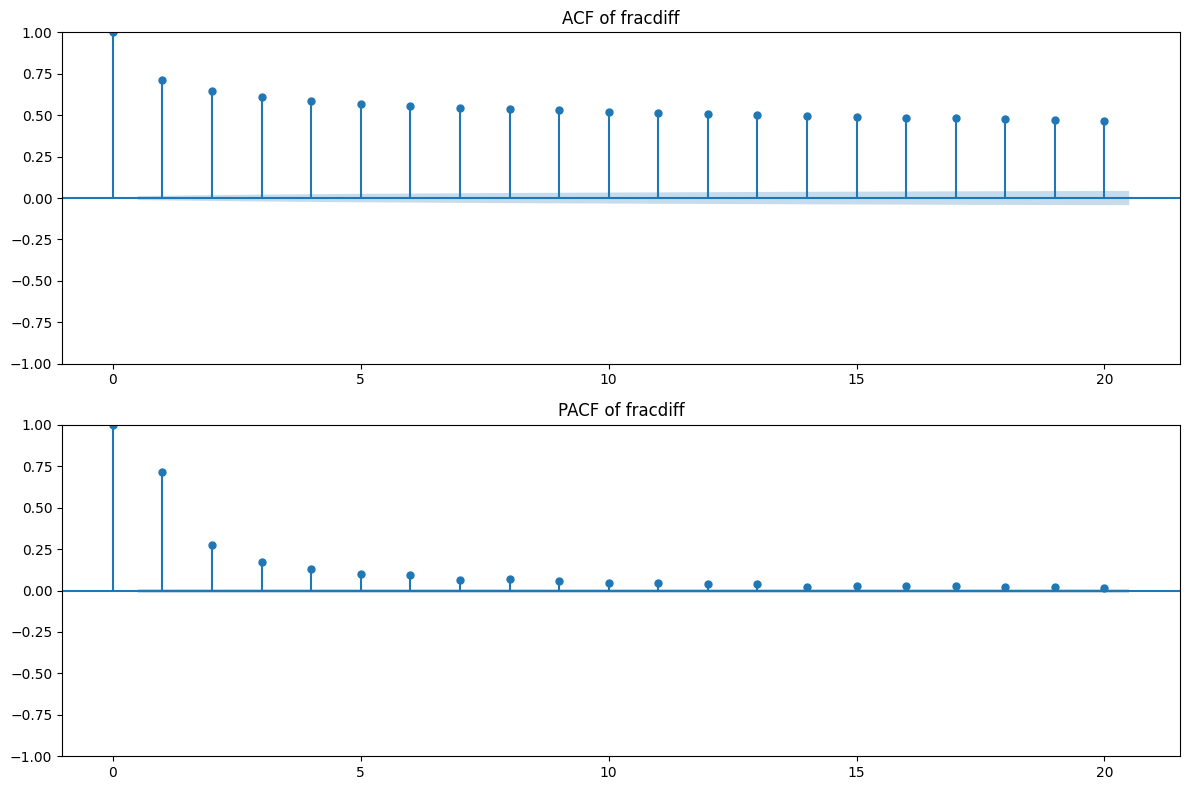

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df['fracdiff'], ax=axes[0], lags=20, title="ACF of fracdiff")
plot_pacf(df['fracdiff'], ax=axes[1], lags=20, title="PACF of fracdiff")
plt.tight_layout()
plt.show()


In [17]:
lags_to_try = [1, 2, 3, 6, 12, 24]

for lag in lags_to_try:
    df[f'fracdiff_lag{lag}'] = df['fracdiff'].shift(lag)

# Normalization

#### Min-max (-1,1)

In [22]:
from sklearn.preprocessing import MinMaxScaler

# 1) Sort your DataFrame by date and split train/test
df = df.sort_values("DateTime")
train_size = int(len(df) * 0.8)

train_df = df.iloc[:train_size].copy()
test_df  = df.iloc[train_size:].copy()

# 2) Separate out the datetime column (so it won't be scaled)
datetime_col = 'DateTime'
train_datetime = train_df[datetime_col]
test_datetime = test_df[datetime_col]

# 3) Identify numeric columns only
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
train_numeric = train_df[numeric_cols]
test_numeric  = test_df[numeric_cols]

# 4) Initialize MinMaxScaler with feature range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))

# 5) Fit on training numeric data only
scaler.fit(train_numeric)

# 6) Transform both train and test numeric subsets
train_scaled_arr = scaler.transform(train_numeric)
test_scaled_arr  = scaler.transform(test_numeric)

# 7) Reconstruct scaled DataFrames
train_scaled_df = pd.DataFrame(train_scaled_arr, 
                               columns=numeric_cols, 
                               index=train_numeric.index)
test_scaled_df  = pd.DataFrame(test_scaled_arr, 
                               columns=numeric_cols, 
                               index=test_numeric.index)

# 8) (Optional) Add back the DateTime column
train_scaled_df[datetime_col] = train_datetime
test_scaled_df[datetime_col]  = test_datetime

# 9) Reorder columns to put DateTime first, if desired
cols_order = [datetime_col] + list(numeric_cols)
train_scaled_df = train_scaled_df[cols_order]
test_scaled_df = test_scaled_df[cols_order]

# (Optional) Concatenate back if you prefer one DataFrame
df_scaled = pd.concat([train_scaled_df, test_scaled_df]).sort_index()

#### Standardization
todo for deep learning

# Dimmension reduction

In [23]:
df.columns

Index(['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'log_ret',
       'fracdiff', 'Return_next_10', 'ReturnBin10', 'ReturnBinQuantile',
       'ReturnBin10_manual', 'ReturnBin10_manual_bell', 'RSI', 'MACD',
       'MACD_signal', 'MACD_diff', '%K', '%D', 'ATR', 'Hour', 'DayOfWeek',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
       'fracdiff_lag1', 'fracdiff_lag2', 'fracdiff_lag3', 'fracdiff_lag6',
       'fracdiff_lag12', 'fracdiff_lag24'],
      dtype='object')

# External features

In [19]:
# Sentiment and External Variables (Advanced)
# While not strictly derived from the OHLCV dataset, including external data—like sentiment from social media (Twitter, Reddit), Google Trends, or blockchain metrics (e.g., on-chain transactions, hash rate)—often adds predictive power for crypto assets (Li et al., 2020).
# Potential External Features
# Social Media Sentiment Scores (e.g., VADER, BERT-based)
# Search Trends (Google Trends, Baidu Index)
# On-Chain Metrics:
# Active addresses
# Hash rate, mining difficulty
# Exchange flows (inflow/outflow)
# 	- menove pary
# 	- kryptove pary
# 	- zlato
# 	- indexy
# 	- ine krypto
# 	- bondy
# 	- urokove sadzby US (alebo proxy)
# 	- urokove sadzby eu
# 	- urokove sadzby ostatne hlavne krajiny
